In [5]:
#Đọc dữ liệu
import json 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

with open('vn_plagiarism_corpus.json', 'r', encoding='utf-8') as f:
    corpus_data = json.load(f)
with open('vn_plagiarism_queries.json', 'r', encoding='utf-8') as f:
    queries_data = json.load(f)

print(f"corpus: {len(corpus_data)} documents")
print(f"queries_data: {len(queries_data)} queries")

plagiarism_counts = {}
for query in queries_data:
    ptype = query['plagiarism_type']
    plagiarism_counts[ptype] = plagiarism_counts.get(ptype, 0) + 1

print(f"\nPhân bố các loại đạo văn:")
for ptype, count in sorted(plagiarism_counts.items(), key=lambda x: x[1], reverse=True):
    is_plag = "True" if ptype != "original" else "False"
    print(f"   {is_plag} {ptype}: {count} ({count/len(queries_data)*100:.1f}%)")

# Phân tích độ dài văn bản
query_lengths = [len(q['text'].split()) for q in queries_data]
corpus_lengths = [len(c['text'].split()) for c in corpus_data]

print(f"\nThống kê độ dài:")
print(f"   Query - Min: {min(query_lengths)}, Max: {max(query_lengths)}, Avg: {np.mean(query_lengths):.1f}")
print(f"   Corpus - Min: {min(corpus_lengths)}, Max: {max(corpus_lengths)}, Avg: {np.mean(corpus_lengths):.1f}")

print("\n Dữ liệu đã sẵn sàng cho bước tiếp theo!")

corpus: 2925 documents
queries_data: 10000 queries

Phân bố các loại đạo văn:
   True none: 4000 (40.0%)
   True insertion: 761 (7.6%)
   True mixed_medium: 758 (7.6%)
   True mixed_heavy: 752 (7.5%)
   True copy_partial: 752 (7.5%)
   True deletion: 744 (7.4%)
   True word_order: 740 (7.4%)
   True paraphrase_light: 732 (7.3%)
   True partial_copy: 696 (7.0%)
   True paraphrase_heavy: 65 (0.7%)

Thống kê độ dài:
   Query - Min: 2, Max: 3293, Avg: 618.0
   Corpus - Min: 100, Max: 1994, Avg: 656.2

 Dữ liệu đã sẵn sàng cho bước tiếp theo!


In [6]:
#import thư viện 
import json

import numpy as np
import pandas as pd 
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import time
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

print("import thư viện thành công")

plt.style.use('default')
sns.set_palette('husl')

import thư viện thành công


In [7]:
model_name = "bkai-foundation-models/vietnamese-bi-encoder"

try:
    bi_encoder = SentenceTransformer(model_name)
    print("Load mô hình thành công")
except Exception as e:
    print(f"Lỗi khi tải mô hình '{model_name}': {e}")

Load mô hình thành công


In [8]:
# CHUNKING và lưu lại 

import re
import pickle
import os

class TextChunker:

    
    def __init__(self, chunk_type="adaptive", max_chunk_words=100):
        self.chunk_type = chunk_type  # "sentence", "paragraph", or "adaptive"
        self.max_chunk_words = max_chunk_words  # Max words per chunk
    
    def chunk_text(self, text, doc_id):
        
        word_count = len(text.split())
        
        # Decide chunking strategy
        if self.chunk_type == "adaptive":
            # Long document → Paragraph chunking
            if word_count > 500:
                return self._chunk_by_paragraph(text, doc_id)
            # Short document → Sentence chunking
            else:
                return self._chunk_by_sentence(text, doc_id)
        
        elif self.chunk_type == "paragraph":
            return self._chunk_by_paragraph(text, doc_id)
        
        else:  # sentence
            return self._chunk_by_sentence(text, doc_id)
    
    def _chunk_by_sentence(self, text, doc_id):
        """Original sentence chunking (fine-grained)"""
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if s.strip()]
        
        chunks = []
        for i, sentence in enumerate(sentences):
            chunk = {
                'chunk_id': f"{doc_id}_chunk_{i}",
                'doc_id': doc_id,
                'text': sentence,
                'position': i,
                'length': len(sentence.split())
            }
            chunks.append(chunk)
        
        return chunks
    
    def _chunk_by_paragraph(self, text, doc_id):
        """
        PARAGRAPH CHUNKING (coarse-grained) - For LARGE corpus
        
        Strategy:
        1. Split by double newline (\n\n) or multiple spaces
        2. Merge small paragraphs (< 30 words)
        3. Split large paragraphs (> max_chunk_words)
        """
        
        # Step 1: Split by paragraphs (double newline or 4+ spaces)
        paragraphs = re.split(r'\n\n+|\s{4,}', text)
        paragraphs = [p.strip() for p in paragraphs if p.strip()]
        
        # Step 2: Smart merging/splitting
        chunks = []
        current_chunk = []
        current_length = 0
        
        for para in paragraphs:
            para_words = para.split()
            para_length = len(para_words)
            
            # Case 1: Paragraph quá lớn → Split by sentences
            if para_length > self.max_chunk_words:
                # Flush current chunk
                if current_chunk:
                    chunks.append(' '.join(current_chunk))
                    current_chunk = []
                    current_length = 0
                
                # Split large paragraph by sentences
                sentences = re.split(r'[.!?]+', para)
                sentences = [s.strip() for s in sentences if s.strip()]
                
                temp_chunk = []
                temp_length = 0
                
                for sent in sentences:
                    sent_len = len(sent.split())
                    
                    if temp_length + sent_len > self.max_chunk_words and temp_chunk:
                        chunks.append(' '.join(temp_chunk))
                        temp_chunk = [sent]
                        temp_length = sent_len
                    else:
                        temp_chunk.append(sent)
                        temp_length += sent_len
                
                if temp_chunk:
                    chunks.append(' '.join(temp_chunk))
            
            # Case 2: Merge với chunk hiện tại
            elif current_length + para_length <= self.max_chunk_words:
                current_chunk.append(para)
                current_length += para_length
            
            # Case 3: Flush và start new chunk
            else:
                if current_chunk:
                    chunks.append(' '.join(current_chunk))
                current_chunk = [para]
                current_length = para_length
        
        # Flush remaining
        if current_chunk:
            chunks.append(' '.join(current_chunk))
        
        # Step 3: Create chunk objects
        chunk_objects = []
        for i, chunk_text in enumerate(chunks):
            chunk_objects.append({
                'chunk_id': f"{doc_id}_chunk_{i}",
                'doc_id': doc_id,
                'text': chunk_text,
                'position': i,
                'length': len(chunk_text.split())
            })
        
        return chunk_objects
    
    def chunk_corpus(self, corpus_data):
        """Chunk toàn bộ corpus"""
        all_chunks = []
        
        for doc in corpus_data:
            doc_chunks = self.chunk_text(doc['text'], doc['id'])
            all_chunks.extend(doc_chunks)
        
        return all_chunks

# ===============================================
# SAVE/LOAD CORPUS CHUNKS
# ===============================================
CORPUS_CHUNKS_FILE = 'corpus_chunks.pkl'

if os.path.exists(CORPUS_CHUNKS_FILE):
    print("="*60)
    print("📂 LOADING SAVED CORPUS CHUNKS")
    print("="*60)
    
    start_time = time.time()
    with open(CORPUS_CHUNKS_FILE, 'rb') as f:
        corpus_chunks = pickle.load(f)
    end_time = time.time()
    
    print(f"✅ Loaded {len(corpus_chunks)} chunks")
    print(f"⏱️  Time: {end_time - start_time:.2f}s")
    print(f"   Avg chunks/doc: {len(corpus_chunks)/len(corpus_data):.1f}")
    
else:
    print("="*60)
    print("🔨 CREATING NEW CORPUS CHUNKS")
    print("="*60)
    
    # Tạo chunks
    chunker = TextChunker()
    corpus_chunks = chunker.chunk_corpus(corpus_data)
    
    print(f"✅ Created {len(corpus_chunks)} chunks from {len(corpus_data)} documents")
    print(f"   Avg: {len(corpus_chunks)/len(corpus_data):.1f} chunks/doc")
    
    # Lưu file
    print("\n💾 Saving corpus chunks...")
    with open(CORPUS_CHUNKS_FILE, 'wb') as f:
        pickle.dump(corpus_chunks, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    file_size = os.path.getsize(CORPUS_CHUNKS_FILE) / 1024 / 1024
    print(f"✅ Saved to {CORPUS_CHUNKS_FILE} (~{file_size:.1f} MB)")

# Create chunker instance for later use
chunker = TextChunker()

# Hiển thị mẫu
print("\n📝 Sample chunks:")
for i, chunk in enumerate(corpus_chunks[:3]):
    print(f"{i+1}. [{chunk['chunk_id']}] {chunk['text'][:60]}...")

print("\n" + "="*60)
print("✅ CORPUS CHUNKS READY!")
print("="*60)

📂 LOADING SAVED CORPUS CHUNKS
✅ Loaded 33575 chunks
⏱️  Time: 0.17s
   Avg chunks/doc: 11.5

📝 Sample chunks:
1. [doc_1_chunk_0] Bảo mật là sự hạn chế khả năng lạm dụng tài nguyên và tài sả...
2. [doc_1_chunk_1] Bảo mật trở nên đặc biệt phức tạp trong quản lý, vận hành nh...
3. [doc_1_chunk_2] Hạn chế ở đây có ý rằng không thể triệt phá hết ngay việc lạ...

✅ CORPUS CHUNKS READY!


In [9]:
#Tạo embeddings cho chunks 

import os
import pickle
import numpy as np
import faiss

# ===============================================
# FILE PATHS
# ===============================================
EMBEDDINGS_FILE = 'chunk_embeddings_normalized.npy'
FAISS_INDEX_FILE = 'chunk_faiss_index.faiss'
CHUNK_METADATA_FILE = 'chunk_metadata.pkl'

# ===============================================
# HELPER: VALIDATE EMBEDDINGS
# ===============================================
def validate_embeddings(embeddings, name="embeddings"):
    """
    Kiểm tra embeddings có hợp lệ không
    
    Returns:
        bool: True if valid, False otherwise
    """
    # Check for NaN
    nan_count = np.isnan(embeddings).sum()
    if nan_count > 0:
        print(f"❌ ERROR: {name} contains {nan_count} NaN values!")
        return False
    
    # Check for Inf
    inf_count = np.isinf(embeddings).sum()
    if inf_count > 0:
        print(f"❌ ERROR: {name} contains {inf_count} Inf values!")
        return False
    
    # Check norm
    norms = np.linalg.norm(embeddings, axis=1)
    zero_norm_count = (norms < 1e-8).sum()
    if zero_norm_count > 0:
        print(f"⚠️  WARNING: {zero_norm_count} embeddings have near-zero norm!")
    
    # Check range
    min_val = embeddings.min()
    max_val = embeddings.max()
    print(f"✅ {name} validation:")
    print(f"   Shape: {embeddings.shape}")
    print(f"   Range: [{min_val:.6f}, {max_val:.6f}]")
    print(f"   Norm: [{norms.min():.6f}, {norms.max():.6f}]")
    
    return True

# ===============================================
# LOAD OR CREATE
# ===============================================
if (os.path.exists(EMBEDDINGS_FILE) and 
    os.path.exists(FAISS_INDEX_FILE) and 
    os.path.exists(CHUNK_METADATA_FILE)):
    
    print("="*60)
    print("📂 LOADING SAVED EMBEDDINGS + FAISS INDEX")
    print("="*60)
    
    start_time = time.time()
    
    # Load embeddings
    chunk_embeddings_normalized = np.load(EMBEDDINGS_FILE)
    print(f"✅ Loaded embeddings: {chunk_embeddings_normalized.shape}")
    
    # VALIDATE LOADED EMBEDDINGS
    if not validate_embeddings(chunk_embeddings_normalized, "Loaded embeddings"):
        print("\n⚠️  CORRUPTED FILE DETECTED!")
        print("   Deleting and recreating...")
        os.remove(EMBEDDINGS_FILE)
        os.remove(FAISS_INDEX_FILE)
        os.remove(CHUNK_METADATA_FILE)
        raise ValueError("Corrupted files deleted. Please re-run this cell.")
    
    # Load FAISS index
    embedding_dim = chunk_embeddings_normalized.shape[1]
    chunk_faiss_index = faiss.read_index(FAISS_INDEX_FILE)
    print(f"✅ Loaded FAISS index: {chunk_faiss_index.ntotal} vectors")
    
    # Load metadata
    with open(CHUNK_METADATA_FILE, 'rb') as f:
        metadata = pickle.load(f)
    chunk_ids = metadata['chunk_ids']
    print(f"✅ Loaded metadata: {len(chunk_ids)} chunk IDs")
    
    # TEST FAISS INDEX
    print(f"\n🧪 Testing FAISS index...")
    test_query = chunk_embeddings_normalized[0:1].astype('float32')
    test_similarities, test_indices = chunk_faiss_index.search(test_query, k=5)
    
    if np.isfinite(test_similarities).all():
        print(f"✅ FAISS test passed! Similarity range: [{test_similarities[0].min():.6f}, {test_similarities[0].max():.6f}]")
    else:
        print(f"❌ FAISS index CORRUPTED! Deleting...")
        os.remove(EMBEDDINGS_FILE)
        os.remove(FAISS_INDEX_FILE)
        os.remove(CHUNK_METADATA_FILE)
        raise ValueError("Corrupted FAISS index deleted. Please re-run this cell.")
    
    end_time = time.time()
    print(f"\n⏱️  Loading time: {end_time - start_time:.2f}s")
    print(f"🚀 Ready!")
    
else:
    print("="*60)
    print("🔨 CREATING NEW EMBEDDINGS + FAISS INDEX")
    print("="*60)
    
    # Extract texts
    chunk_texts = [chunk['text'] for chunk in corpus_chunks]
    chunk_ids = [chunk['chunk_id'] for chunk in corpus_chunks]
    
    print(f"📊 Creating embeddings for {len(chunk_texts)} chunks...")
    
    # Create embeddings
    start_time = time.time()
    chunk_embeddings = bi_encoder.encode(
        chunk_texts,
        show_progress_bar=True,
        batch_size=32,
        convert_to_numpy=True
    )
    
    print(f"\n🔍 Validating raw embeddings...")
    if not validate_embeddings(chunk_embeddings, "Raw embeddings"):
        raise ValueError("Raw embeddings are invalid! Check bi_encoder model.")
    
    # Normalize (WITH SAFETY CHECK)
    print(f"\n🔄 Normalizing embeddings...")
    norms = np.linalg.norm(chunk_embeddings, axis=1, keepdims=True)
    
    # Replace zero norms with 1.0 to avoid division by zero
    zero_norm_mask = (norms < 1e-8)
    if zero_norm_mask.any():
        print(f"⚠️  Found {zero_norm_mask.sum()} zero-norm embeddings, fixing...")
        norms[zero_norm_mask] = 1.0
    
    chunk_embeddings_normalized = chunk_embeddings / norms
    
    # Validate normalized embeddings
    print(f"\n🔍 Validating normalized embeddings...")
    if not validate_embeddings(chunk_embeddings_normalized, "Normalized embeddings"):
        raise ValueError("Normalized embeddings are invalid!")
    
    end_time = time.time()
    print(f"\n✅ Embeddings created and validated!")
    print(f"   Time: {end_time - start_time:.2f}s")
    
    # Create FAISS index
    print("\n🔧 Creating FAISS index...")
    embedding_dim = chunk_embeddings_normalized.shape[1]
    
    # Use IndexFlatIP for small corpus
    chunk_faiss_index = faiss.IndexFlatIP(embedding_dim)
    
    # Add vectors (convert to float32 explicitly)
    vectors_to_add = chunk_embeddings_normalized.astype('float32')
    
    # Final validation before adding
    if not np.isfinite(vectors_to_add).all():
        raise ValueError("Non-finite values detected before adding to FAISS!")
    
    chunk_faiss_index.add(vectors_to_add)
    
    print(f"✅ FAISS index created: {chunk_faiss_index.ntotal} vectors")
    
    # TEST FAISS INDEX
    print("\n🧪 Testing FAISS index...")
    test_query = chunk_embeddings_normalized[0:1].astype('float32')
    test_similarities, test_indices = chunk_faiss_index.search(test_query, k=5)
    
    print(f"   Test similarities: {test_similarities[0][:5]}")
    
    if np.isfinite(test_similarities).all():
        print(f"✅ FAISS index test PASSED!")
    else:
        print(f"❌ FAISS index test FAILED!")
        raise ValueError("FAISS index is corrupted!")
    
    # Save everything
    print("\n💾 Saving to disk...")
    
    # Save embeddings
    np.save(EMBEDDINGS_FILE, chunk_embeddings_normalized)
    emb_size = os.path.getsize(EMBEDDINGS_FILE) / 1024 / 1024
    print(f"✅ Saved: {EMBEDDINGS_FILE} (~{emb_size:.1f} MB)")
    
    # Save FAISS index
    faiss.write_index(chunk_faiss_index, FAISS_INDEX_FILE)
    faiss_size = os.path.getsize(FAISS_INDEX_FILE) / 1024 / 1024
    print(f"✅ Saved: {FAISS_INDEX_FILE} (~{faiss_size:.1f} MB)")
    
    # Save metadata
    metadata = {
        'chunk_ids': chunk_ids,
        'num_chunks': len(chunk_ids),
        'embedding_dim': embedding_dim,
        'model_name': 'bkai-foundation-models/vietnamese-bi-encoder'
    }
    with open(CHUNK_METADATA_FILE, 'wb') as f:
        pickle.dump(metadata, f)
    print(f"✅ Saved: {CHUNK_METADATA_FILE}")
    
    print(f"\n🎉 All files saved! Next run will be faster!")

print("\n" + "="*60)
print("✅ CHUNK EMBEDDINGS + FAISS INDEX READY!")
print("="*60)

📂 LOADING SAVED EMBEDDINGS + FAISS INDEX
✅ Loaded embeddings: (33575, 768)
✅ Loaded embeddings validation:
   Shape: (33575, 768)
   Range: [-0.259571, 0.298893]
   Norm: [1.000000, 1.000000]
✅ Loaded FAISS index: 33575 vectors
✅ Loaded metadata: 33575 chunk IDs

🧪 Testing FAISS index...
✅ FAISS test passed! Similarity range: [0.497798, 1.000000]

⏱️  Loading time: 1.07s
🚀 Ready!

✅ CHUNK EMBEDDINGS + FAISS INDEX READY!


In [10]:
# Document scoring với chuẩn hóa mềm để giảm bão hòa điểm
class DocumentScorer:
    def __init__(self, corpus_chunks, weights=None, score_center=0.55, score_scale=4.0):
        self.corpus_chunks = corpus_chunks
        self.weights = weights or {
            'doc_max': 0.40,
            'doc_mean': 0.20,
            'doc_count': 0.15,
            'doc_contiguous': 0.10,
            'doc_coverage': 0.10,
            'chunk_density': 0.05,
            'span_penalty': 0.05
        }
        self.score_center = score_center
        self.score_scale = score_scale
        self.chunk_map = {chunk['chunk_id']: chunk for chunk in corpus_chunks}
        self.doc_chunks_map = {}
        for chunk in corpus_chunks:
            self.doc_chunks_map.setdefault(chunk['doc_id'], []).append(chunk)

    def calculate_doc_scores(self, top_k_results):
        doc_similarities = {}
        for similarity, chunk_idx in top_k_results:
            chunk = self.corpus_chunks[chunk_idx]
            doc_id = chunk['doc_id']
            doc_similarities.setdefault(doc_id, []).append({
                'similarity': similarity,
                'chunk': chunk,
                'chunk_idx': chunk_idx
            })

        doc_scores = []
        for doc_id, chunk_sims in doc_similarities.items():
            similarities = [cs['similarity'] for cs in chunk_sims]
            doc_max = max(similarities)
            doc_mean = np.mean(similarities)
            total_doc_chunks = len(self.doc_chunks_map[doc_id])
            coverage_ratio = min(len(similarities) / total_doc_chunks, 1.0)
            doc_count = coverage_ratio  # giữ tương thích tên cũ

            positions = sorted(cs['chunk']['position'] for cs in chunk_sims)
            doc_contiguous, max_group_len = self._calculate_contiguous_score(positions)
            span = positions[-1] - positions[0] + 1 if len(positions) > 1 else 1
            span_ratio = min(span / total_doc_chunks, 1.0)
            chunk_density = min(coverage_ratio / max(span_ratio, 1e-6), 1.0)
            chunk_similarity_std = float(np.std(similarities)) if len(similarities) > 1 else 0.0

            raw_score = (
                self.weights['doc_max'] * doc_max +
                self.weights['doc_mean'] * doc_mean +
                self.weights['doc_count'] * doc_count +
                self.weights['doc_contiguous'] * doc_contiguous +
                self.weights['doc_coverage'] * coverage_ratio +
                self.weights['chunk_density'] * chunk_density -
                self.weights['span_penalty'] * (1.0 - span_ratio)
            )

            logistic_input = self.score_scale * (raw_score - self.score_center)
            final_score = 1.0 / (1.0 + np.exp(-logistic_input))

            doc_scores.append({
                'doc_id': doc_id,
                'doc_max': doc_max,
                'doc_mean': doc_mean,
                'doc_count': doc_count,
                'doc_contiguous': doc_contiguous,
                'final_score': final_score,
                'raw_score': raw_score,
                'chunk_similarity_std': chunk_similarity_std,
                'position_span_ratio': span_ratio,
                'chunk_density': chunk_density,
                'contiguous_len': max_group_len,
                'chunks': chunk_sims,
                'num_chunks': len(chunk_sims)
            })

        doc_scores.sort(key=lambda x: x['final_score'], reverse=True)
        return doc_scores

    def _calculate_contiguous_score(self, positions):
        if len(positions) <= 1:
            return 0.0, len(positions)
        contiguous_groups = []
        current_group = [positions[0]]
        for i in range(1, len(positions)):
            if positions[i] - positions[i-1] <= 2:
                current_group.append(positions[i])
            else:
                contiguous_groups.append(len(current_group))
                current_group = [positions[i]]
        contiguous_groups.append(len(current_group))
        max_contiguous = max(contiguous_groups)
        score = min(max_contiguous / len(positions), 1.0)
        return score, max_contiguous


doc_scorer = DocumentScorer(corpus_chunks)
print("Document Scorer ready!")
print(f" Weights: {doc_scorer.weights}")

Document Scorer ready!
 Weights: {'doc_max': 0.4, 'doc_mean': 0.2, 'doc_count': 0.15, 'doc_contiguous': 0.1, 'doc_coverage': 0.1, 'chunk_density': 0.05, 'span_penalty': 0.05}


In [11]:
 
# BI-ENCODER PIPELINE
# Mục đích: Tìm top 100 corpus chunks giống nhất với các chunk của query

def bi_encoder_search_chunked(query_text, query_id="query_temp", top_k=100):
    
    # Bước 1: Chia query thành chunks
    query_chunks = chunker.chunk_text(query_text, doc_id=query_id)
    print(f"   Query được chia thành {len(query_chunks)} chunks")
    
    # Bước 2: Tạo embeddings cho TẤT CẢ query chunks
    query_texts = [chunk['text'] for chunk in query_chunks]
    query_embeddings = bi_encoder.encode(query_texts, convert_to_numpy=True)
    
    # Normalize query embeddings
    query_norms = np.linalg.norm(query_embeddings, axis=1, keepdims=True)
    query_norms[query_norms < 1e-8] = 1.0  # Tránh chia cho 0
    query_embeddings_normalized = query_embeddings / query_norms
    
    # VALIDATE query embeddings
    if not np.isfinite(query_embeddings_normalized).all():
        print(f"   ⚠️ Some query chunks have invalid embeddings!")
        # Loại bỏ query chunks có invalid embeddings
        valid_mask = np.isfinite(query_embeddings_normalized).all(axis=1)
        query_embeddings_normalized = query_embeddings_normalized[valid_mask]
        print(f"   Keeping {valid_mask.sum()}/{len(query_chunks)} valid query chunks")
    
    if len(query_embeddings_normalized) == 0:
        print(f"   ❌ No valid query embeddings!")
        return []
    
    # Bước 3: Tính similarity giữa TỪNG corpus chunk với TẤT CẢ query chunks
    # Shape: (num_query_chunks, num_corpus_chunks)
    similarity_matrix = np.dot(
        query_embeddings_normalized.astype('float32'),
        chunk_embeddings_normalized.T.astype('float32')
    )
    
    # VALIDATE similarity matrix
    if not np.isfinite(similarity_matrix).all():
        print(f"   ⚠️ Similarity matrix contains invalid values!")
        similarity_matrix = np.nan_to_num(similarity_matrix, nan=0.0, posinf=1.0, neginf=0.0)
    
    # Bước 4: Aggregate similarity cho mỗi corpus chunk
    # Strategy: Lấy MAX similarity với bất kỳ query chunk nào
    # (vì nếu corpus chunk giống với BẤT KỲ phần nào của query → có khả năng plagiarism)
    corpus_scores = np.max(similarity_matrix, axis=0)  # Shape: (num_corpus_chunks,)
    
    print(f"   Computed similarity với {len(corpus_scores)} corpus chunks")
    print(f"   Similarity range: [{corpus_scores.min():.6f}, {corpus_scores.max():.6f}]")
    
    # Bước 5: Lấy top-K corpus chunks
    top_k_actual = min(top_k, len(corpus_scores))
    top_k_indices = np.argsort(corpus_scores)[::-1][:top_k_actual]
    
    # Convert to results format: [(similarity, chunk_idx), ...]
    results = [(float(corpus_scores[idx]), int(idx)) for idx in top_k_indices]
    
    print(f"   Selected top {len(results)} corpus chunks")
    
    return results

# Test với một query
test_query = queries_data[33]
print(f"🧪 TEST BI-ENCODER PIPELINE WITH QUERY CHUNKING")
print(f"="*60)
print(f"Query ID: {test_query['id']}")
print(f"Query: {test_query['text'][:100]}...")
print(f"Query length: {len(test_query['text'].split())} words")
print(f"True label: {'PLAGIARISM' if test_query['is_plagiarism'] else 'ORIGINAL'}")
print(f"True type: {test_query['plagiarism_type']}")

# Bi-encoder search with chunking (tìm top-100 corpus chunks giống nhất với toàn bộ query)
print(f"\n🔍 Chunking query and searching top 100 similar corpus chunks...")
bi_results = bi_encoder_search_chunked(test_query['text'], query_id=test_query['id'], top_k=100)

if len(bi_results) > 0:
    print(f"\n✅ Found {len(bi_results)} unique chunks")
    print(f"   Similarity range: [{bi_results[-1][0]:.6f}, {bi_results[0][0]:.6f}]")
    
    # Document scoring
    doc_scores = doc_scorer.calculate_doc_scores(bi_results)
    print(f"\n📊 Document scores (Top 10):")
    print("="*60)
    
    for i, doc_score in enumerate(doc_scores[:10]):
        print(f"{i+1}. Doc: {doc_score['doc_id']} | Chunks: {doc_score['num_chunks']}")
        print(f"    Final: {doc_score['final_score']:.3f}")
        print(f"    Max: {doc_score['doc_max']:.3f} | Mean: {doc_score['doc_mean']:.3f}")
        print(f"    Count: {doc_score['doc_count']:.3f} | Contiguous: {doc_score['doc_contiguous']:.3f}")
        print()
    
    print(f"🎯 Best match: {doc_scores[0]['doc_id']} (score: {doc_scores[0]['final_score']:.3f})")
    
    # Kiểm tra xem có đúng source document không (nếu là plagiarism)
    if test_query['is_plagiarism'] and test_query.get('source_doc_id'):
        source_rank = None
        for i, doc_score in enumerate(doc_scores):
            if doc_score['doc_id'] == test_query['source_doc_id']:
                source_rank = i + 1
                break
        
        if source_rank:
            print(f"✅ Source document {test_query['source_doc_id']} found at rank {source_rank}")
        else:
            print(f"❌ Source document {test_query['source_doc_id']} NOT in top results")
    else:
        print(f"ℹ️  This is an original text (no plagiarism)")
else:
    print(f"❌ No valid results found!")

print("="*60)


🧪 TEST BI-ENCODER PIPELINE WITH QUERY CHUNKING
Query ID: 34
Query: Niklas Zennström sinh ngày 16 tháng 2 năm 1966 là người Thụy Điển có sáng kiến lập doanh nghiệp mới....
Query length: 945 words
True label: ORIGINAL
True type: none

🔍 Chunking query and searching top 100 similar corpus chunks...
   Query được chia thành 12 chunks
   Computed similarity với 33575 corpus chunks
   Similarity range: [-0.067295, 1.000000]
   Selected top 100 corpus chunks

✅ Found 100 unique chunks
   Similarity range: [0.333368, 1.000000]

📊 Document scores (Top 10):
1. Doc: doc_34 | Chunks: 12
    Final: 0.858
    Max: 1.000 | Mean: 1.000
    Count: 1.000 | Contiguous: 1.000

2. Doc: doc_11 | Chunks: 14
    Final: 0.643
    Max: 0.697 | Mean: 0.462
    Count: 0.778 | Contiguous: 0.929

3. Doc: doc_542 | Chunks: 2
    Final: 0.364
    Max: 0.351 | Mean: 0.350
    Count: 0.333 | Contiguous: 1.000

4. Doc: doc_7 | Chunks: 2
    Final: 0.352
    Max: 0.371 | Mean: 0.363
    Count: 0.286 | Contiguous: 1.000



In [12]:
# MỞ RỘNG NGỮ CẢNH CHO CHUNKS

class ContextExpander:
    def __init__(self, corpus_chunks, corpus_data):
        self.corpus_chunks = corpus_chunks
        self.corpus_data = corpus_data
        
        self.doc_text_map = {doc['id']: doc['text'] for doc in corpus_data}
        self.doc_chunks_map = {}
        for chunk in corpus_chunks:
            doc_id = chunk['doc_id']
            self.doc_chunks_map.setdefault(doc_id, []).append(chunk)
        for doc_id in self.doc_chunks_map:
            self.doc_chunks_map[doc_id].sort(key=lambda x: x['position'])
    
    def expand_chunk_context(self, chunk, context_window=1):
        doc_id = chunk['doc_id']
        position = chunk['position']
        doc_chunks = self.doc_chunks_map[doc_id]
        current_idx = next((idx for idx, c in enumerate(doc_chunks) if c['position'] == position), None)
        if current_idx is None:
            return chunk['text']
        start_idx = max(0, current_idx - context_window)
        end_idx = min(len(doc_chunks), current_idx + context_window + 1)
        context_chunks = doc_chunks[start_idx:end_idx]
        return " ".join([c['text'] for c in context_chunks])
    
    def get_best_chunks_per_doc(self, doc_scores, top_n_docs=10, chunks_per_doc=1):
        best_chunks = []
        for doc_score in doc_scores[:top_n_docs]:
            sorted_chunks = sorted(doc_score['chunks'], key=lambda x: x['similarity'], reverse=True)
            selected_chunks = sorted_chunks if chunks_per_doc == -1 else sorted_chunks[:chunks_per_doc]
            for chunk_data in selected_chunks:
                best_chunks.append({
                    'doc_id': doc_score['doc_id'],
                    'chunk': chunk_data['chunk'],
                    'chunk_similarity': chunk_data['similarity'],
                    'doc_final_score': doc_score['final_score'],
                    'doc_max': doc_score['doc_max'],
                    'doc_mean': doc_score['doc_mean'],
                    'doc_count': doc_score['doc_count'],
                    'doc_contiguous': doc_score['doc_contiguous']
                })
        return best_chunks
    
    def get_best_chunk_per_doc(self, doc_scores, top_n=15):
        return self.get_best_chunks_per_doc(doc_scores, top_n_docs=top_n, chunks_per_doc=1)

context_expander = ContextExpander(corpus_chunks, corpus_data)
print("✅ Context Expander ready!")

✅ Context Expander ready!


In [13]:

class CompletePlagiarismDetector:
    def __init__(self, bi_encoder, chunk_faiss_index, corpus_chunks, corpus_data,
                 doc_scorer, context_expander,
                 query_chunker=None, max_query_chunks=10, threshold=0.7):
        self.bi_encoder = bi_encoder
        self.chunk_faiss_index = chunk_faiss_index  # optional, not required for dot-product path
        self.corpus_chunks = corpus_chunks
        self.corpus_data = corpus_data
        self.doc_scorer = doc_scorer
        self.context_expander = context_expander
        self.query_chunker = query_chunker or TextChunker()
        self.max_query_chunks = max_query_chunks
        self.threshold = threshold

    def detect(self, query_text, top_k=100, top_n_docs=15, use_faiss=False, verbose=False):
        if verbose:
            print("="*60)
            print("PLAGIARISM DETECTION PIPELINE (BI-ENCODER ONLY)")
            print("="*60)

        # Step 1: chunk query
        query_chunks = self.query_chunker.chunk_text(query_text, doc_id="query")
        if self.max_query_chunks and len(query_chunks) > self.max_query_chunks:
            query_chunks = query_chunks[:self.max_query_chunks]
        query_texts = [c['text'] for c in query_chunks]
        word_count = len(query_text.split())

        if len(query_texts) == 0:
            return {
                'prediction': False,
                'confidence': 0.0,
                'threshold': self.threshold,
                'best_match': None,
                'top_results': [],
                'doc_scores': [],
                'method': 'bi-encoder',
                'query_chunks': 0,
                'query_words': word_count,
                'corpus_matches': 0
            }

        if verbose:
            print(f"Step 1: Query words: {word_count}, chunks: {len(query_texts)}")

        # Step 2: embed query chunks
        q_emb = self.bi_encoder.encode(query_texts, show_progress_bar=False, convert_to_numpy=True)
        q_norms = np.linalg.norm(q_emb, axis=1, keepdims=True)
        q_norms[q_norms < 1e-8] = 1.0
        q_emb_norm = q_emb / q_norms

        if use_faiss and hasattr(self, 'chunk_faiss_index') and self.chunk_faiss_index is not None:
            # per-chunk FAISS search aggregation (safe)
            corpus_chunk_scores = {}
            per_chunk_k = min(top_k, self.chunk_faiss_index.ntotal)
            for i, qv in enumerate(q_emb_norm):
                if not np.isfinite(qv).all():
                    continue
                sims, idxs = self.chunk_faiss_index.search(qv.reshape(1, -1).astype('float32'), per_chunk_k)
                sims = sims[0]; idxs = idxs[0]
                # sanitize
                sims = np.nan_to_num(sims, nan=0.0, posinf=1.0, neginf=0.0)
                for j, corpus_idx in enumerate(idxs):
                    sim = float(sims[j])
                    if not np.isfinite(sim):
                        continue
                    if corpus_idx not in corpus_chunk_scores:
                        corpus_chunk_scores[corpus_idx] = {'max_similarity': sim, 'query_chunks':[i]}
                    else:
                        if sim > corpus_chunk_scores[corpus_idx]['max_similarity']:
                            corpus_chunk_scores[corpus_idx]['max_similarity'] = sim
                        if i not in corpus_chunk_scores[corpus_idx]['query_chunks']:
                            corpus_chunk_scores[corpus_idx]['query_chunks'].append(i)
            bi_results = [(v['max_similarity'], int(k)) for k, v in corpus_chunk_scores.items()]
            bi_results.sort(reverse=True, key=lambda x: x[0])
            bi_results = bi_results[:top_k]
        else:
            # dot-product matrix path (fast if chunk_embeddings_normalized is in memory)
            # requires chunk_embeddings_normalized to exist in notebook scope
            similarity_matrix = np.dot(q_emb_norm.astype('float32'), chunk_embeddings_normalized.T.astype('float32'))
            if not np.isfinite(similarity_matrix).all():
                similarity_matrix = np.nan_to_num(similarity_matrix, nan=0.0, posinf=1.0, neginf=0.0)
            corpus_scores = np.max(similarity_matrix, axis=0)  # max over query chunks
            top_k_actual = min(top_k, len(corpus_scores))
            top_k_indices = np.argsort(corpus_scores)[::-1][:top_k_actual]
            bi_results = [(float(corpus_scores[idx]), int(idx)) for idx in top_k_indices]

        if verbose:
            if len(bi_results) > 0:
                print(f"Step 2: Selected top {len(bi_results)} corpus chunks | sim range [{bi_results[-1][0]:.6f}, {bi_results[0][0]:.6f}]")
            else:
                print("Step 2: No matching corpus chunks found")

        # Step 3: document scoring
        doc_scores = self.doc_scorer.calculate_doc_scores(bi_results)
        if verbose:
            print(f"Step 3: Scored {len(doc_scores)} documents")

        # Step 4: select best chunk per doc
        best_chunks = self.context_expander.get_best_chunk_per_doc(doc_scores, top_n=top_n_docs)
        if verbose:
            print(f"Step 4: Selected {len(best_chunks)} best chunks from top-{top_n_docs} docs")

        # Final: use document final_score as confidence
        best_doc = doc_scores[0] if len(doc_scores) > 0 else None
        confidence = float(best_doc['final_score']) if best_doc is not None else 0.0
        is_plagiarism = confidence >= self.threshold

        if verbose:
            print("\n" + "="*60)
            print("⭐ FINAL RESULT:")
            print(f"   Prediction: {'PLAGIARISM' if is_plagiarism else 'ORIGINAL'}")
            print(f"   Confidence: {confidence:.3f}")
            print(f"   Threshold: {self.threshold}")
            if best_doc:
                print(f"   Best match doc: {best_doc['doc_id']} (final_score: {best_doc['final_score']:.3f})")
            print("="*60)

        return {
            'prediction': bool(is_plagiarism),
            'confidence': confidence,
            'threshold': self.threshold,
            'best_match': best_doc,
            'top_results': doc_scores[:top_n_docs],
            'doc_scores': doc_scores[:5],
            'method': 'bi-encoder',
            'query_chunks': len(query_chunks),
            'query_words': word_count,
            'corpus_matches': len(bi_results)
        }


print("="*60)
print("CREATING PLAGIARISM DETECTOR")
print("="*60)

complete_detector_v2 = CompletePlagiarismDetector(
    bi_encoder=bi_encoder,
    chunk_faiss_index=chunk_faiss_index,
    corpus_chunks=corpus_chunks,
    corpus_data=corpus_data,
    doc_scorer=doc_scorer,
    context_expander=context_expander,
    query_chunker=chunker,
    max_query_chunks=10,
    threshold=0.6   # adjust as needed
)

print("✅ Complete Plagiarism Detector (bi-encoder) ready!")
print(f"\n📊 Configuration:")
print(f"   Threshold: {complete_detector_v2.threshold}")
print(f"   Max query chunks: {complete_detector_v2.max_query_chunks}")
print(f"   Method: {complete_detector_v2.__class__.__name__} -> bi-encoder only")
# ...existing code...

CREATING PLAGIARISM DETECTOR
✅ Complete Plagiarism Detector (bi-encoder) ready!

📊 Configuration:
   Threshold: 0.6
   Max query chunks: 10
   Method: CompletePlagiarismDetector -> bi-encoder only


In [14]:
# BƯỚC 13A: ML CLASSIFIER CLASS
# Bỏ qua
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import os

class MLClassifier:
    """
    Machine Learning Classifier cho Plagiarism Detection
    Tận dụng đặc trưng doc-level từ bi-encoder/doc scoring + thống kê coverage.
    """

    def __init__(self, model_type='xgboost', decision_threshold=0.5, confidence_scaling='best_final'):
        self.model_type = model_type
        if model_type == 'xgboost':
            self.model = XGBClassifier(
                n_estimators=120,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.9,
                colsample_bytree=0.9,
                random_state=42,
                eval_metric='logloss'
            )
        else:
            raise ValueError(f"Model type {model_type} not supported")

        self.feature_names = [
            'best_final',
            'raw_score',
            'doc_max',
            'doc_mean',
            'doc_count',
            'doc_contiguous',
            'chunk_similarity_std',
            'position_span_ratio',
            'chunk_density',
            'top_final_std',
            'top_final_gap',
            'best_chunks_ratio'
        ]
        self.is_trained = False
        self.decision_threshold = decision_threshold
        self.confidence_scaling = confidence_scaling
        self.min_confidence_floor = 0.0

    def _apply_confidence_scaling(self, raw_confidence, features):
        if self.confidence_scaling == 'best_final':
            best_final = max(float(features[0]), self.min_confidence_floor)
            return raw_confidence * best_final
        return raw_confidence

    def extract_features(self, result):
        best_match = result.get('best_match')
        top_results = result.get('top_results', []) or []
        if not best_match or len(top_results) == 0:
            return [0.0] * len(self.feature_names)

        best_final = float(best_match.get('final_score', 0.0))
        raw_score = float(best_match.get('raw_score', best_final))
        doc_max = float(best_match.get('doc_max', 0.0))
        doc_mean = float(best_match.get('doc_mean', 0.0))
        doc_count = float(best_match.get('doc_count', 0.0))
        doc_contiguous = float(best_match.get('doc_contiguous', 0.0))
        chunk_similarity_std = float(best_match.get('chunk_similarity_std', 0.0))
        position_span_ratio = float(best_match.get('position_span_ratio', 0.0))
        chunk_density = float(best_match.get('chunk_density', 0.0))

        final_scores = [float(d.get('final_score', 0.0)) for d in top_results]
        top_final_std = float(np.std(final_scores)) if len(final_scores) > 1 else 0.0
        top_final_gap = float(final_scores[0] - final_scores[1]) if len(final_scores) > 1 else 0.0

        best_num_chunks = float(best_match.get('num_chunks', 0.0))
        total_top_chunks = float(sum(d.get('num_chunks', 0.0) for d in top_results))
        if total_top_chunks <= 0:
            total_top_chunks = 1.0
        best_chunks_ratio = float(best_num_chunks / total_top_chunks)

        features = [
            best_final,
            raw_score,
            doc_max,
            doc_mean,
            doc_count,
            doc_contiguous,
            chunk_similarity_std,
            position_span_ratio,
            chunk_density,
            top_final_std,
            top_final_gap,
            best_chunks_ratio
        ]
        return features

    def train(self, detector, queries_data, test_size=0.2, verbose=True):
        if verbose:
            print(f"Extracting features từ {len(queries_data)} queries...")
        X, y = [], []
        for i, query in enumerate(queries_data):
            if verbose and (i + 1) % 20 == 0:
                print(f"   Progress: {i+1}/{len(queries_data)}")
            result = detector.detect(query['text'], verbose=False)
            X.append(self.extract_features(result))
            y.append(query['is_plagiarism'])

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        if verbose:
            print(f"\n📊 Dataset split:")
            print(f"   Train: {len(X_train)} samples")
            print(f"   Test:  {len(X_test)} samples")
            print(f"\n🔨 Training {self.model_type.upper()} classifier...")

        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        test_pred = self.model.predict(X_test)
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)
        self.is_trained = True

        if verbose:
            print(f"\n✅ Training completed!")
            print(f"   Train Accuracy: {train_acc*100:.2f}% | F1: {train_f1*100:.2f}%")
            print(f"   Test  Accuracy: {test_acc*100:.2f}% | F1: {test_f1*100:.2f}%")

        if hasattr(self.model, 'feature_importances_'):
            print(f"\n⭐ Feature Importance:")
            for name, imp in sorted(zip(self.feature_names, self.model.feature_importances_),
                                    key=lambda x: x[1], reverse=True):
                print(f"   {name:<20} {imp:>6.3f}")

        return {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'train_pred': train_pred,
            'test_pred': test_pred
        }

    def predict(self, result, decision_threshold=None):
        if not self.is_trained:
            raise ValueError("Model chưa được train! Chạy .train() trước.")
        features = self.extract_features(result)
        raw_prediction = int(self.model.predict([features])[0])
        raw_confidence = float(self.model.predict_proba([features])[0][1])
        calibrated_confidence = self._apply_confidence_scaling(raw_confidence, features)
        threshold = self.decision_threshold if decision_threshold is None else decision_threshold
        prediction = calibrated_confidence >= threshold
        return {
            'prediction': bool(prediction),
            'confidence': float(calibrated_confidence),
            'raw_confidence': raw_confidence,
            'raw_model_prediction': bool(raw_prediction),
            'decision_threshold': threshold,
            'method': 'ml_classifier',
            'features': dict(zip(self.feature_names, features))
        }

    def save(self, filepath='ml_classifier.pkl'):
        if not self.is_trained:
            raise ValueError("Model chưa được train! Không thể lưu.")
        with open(filepath, 'wb') as f:
            pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
        file_size = os.path.getsize(filepath) / 1024 / 1024
        print(f"✅ Đã lưu ML classifier vào: {filepath}")
        print(f"   File size: {file_size:.2f} MB")
        print(f"   Features: {len(self.feature_names)}")

    @staticmethod
    def load(filepath='ml_classifier.pkl'):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File không tồn tại: {filepath}")
        with open(filepath, 'rb') as f:
            classifier = pickle.load(f)
        if not hasattr(classifier, 'decision_threshold'):
            classifier.decision_threshold = 0.5
        if not hasattr(classifier, 'confidence_scaling'):
            classifier.confidence_scaling = 'best_final'
        if not hasattr(classifier, 'min_confidence_floor'):
            classifier.min_confidence_floor = 0.0
        print(f"✅ Đã load ML classifier từ: {filepath}")
        print(f"   Model type: {classifier.model_type}")
        print(f"   Is trained: {classifier.is_trained}")
        print(f"   Features: {len(classifier.feature_names)}")
        print(f"   Decision threshold: {classifier.decision_threshold}")
        return classifier

print("="*60)
print("✅ MLClassifier class created!")
print("="*60)
print("="*60)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# BƯỚC 13B: TRAIN ML CLASSIFIER (WITH SAVE/LOAD)
#Bỏ qua
import os

ML_CLASSIFIER_FILE = 'ml_classifier.pkl'

try:
    active_detector = complete_detector_v2
    print("✅ Sử dụng CompletePlagiarismDetectorV2 (bi-encoder + doc scoring)")
except NameError:
    raise ValueError("DETECTOR NOT FOUND!\n  Variable 'complete_detector_v2' does not exist!\n")

if os.path.exists(ML_CLASSIFIER_FILE):
    print("\n" + "="*60)
    print("📂 LOADING SAVED ML CLASSIFIER")
    print("="*60)
    start_time = time.time()
    ml_classifier = MLClassifier.load(ML_CLASSIFIER_FILE)
    end_time = time.time()
    print(f"⏱️  Time: {end_time - start_time:.2f}s")
else:
    print("\n" + "="*60)
    print("🔨 TRAINING NEW ML CLASSIFIER")
    print("="*60)
    ml_classifier = MLClassifier(model_type='xgboost')
    try:
        training_results = ml_classifier.train(
            detector=active_detector,
            queries_data=queries_data,
            test_size=0.2,
            verbose=True
        )
        print(f"\n{'='*60}")
        print("✅ ML Classifier trained successfully!")
        print("="*60)
        print("\n💾 Saving ML classifier...")
        ml_classifier.save(ML_CLASSIFIER_FILE)
        print("🎉 Next run will load instantly!")
    except Exception as e:
        print(f"\n❌ Error during training: {e}")
        import traceback
        traceback.print_exc()
        print("\n⚠️  SKIPPING ML CLASSIFIER TRAINING")

print("\n" + "="*60)
print("✅ ML CLASSIFIER READY!")
print("="*60)

✅ Sử dụng CompletePlagiarismDetectorV2 (bi-encoder + doc scoring)

📂 LOADING SAVED ML CLASSIFIER
✅ Đã load ML classifier từ: ml_classifier.pkl
   Model type: xgboost
   Is trained: True
   Features: 12
   Decision threshold: 0.5
⏱️  Time: 0.04s

✅ ML CLASSIFIER READY!


In [ ]:
# BƯỚC 13C: ĐÁNH GIÁ NHANH ML CLASSIFIER (KHÔNG DÙNG THRESHOLD)
#Bỏ qua
print(" SO SÁNH NHẸ: ML CLASSIFIER")
print("="*60)

if ml_classifier.is_trained:
    test_indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    comparison_results = []
    
    print(f"\n Testing trên {len(test_indices)} queries...")
    print("-"*60)
    
    for idx in test_indices:
        query = queries_data[idx]
        result = active_detector.detect(query['text'], verbose=False)
        
        ml_result = ml_classifier.predict(result)
        ml_pred = ml_result['prediction']
        ml_conf = ml_result['confidence']
        true_label = query['is_plagiarism']
        ml_correct = (ml_pred == true_label)
        
        comparison_results.append({
            'query_id': query['id'],
            'plag_type': query['plagiarism_type'],
            'true_label': true_label,
            'ml_pred': ml_pred,
            'ml_conf': ml_conf,
            'ml_correct': ml_correct
        })
        
        if idx in [0, 20, 40, 60, 80]:
            print(f"\nQuery {query['id']} ({query['plagiarism_type']}):")
            print(f"  True: {'PLAGIARISM' if true_label else 'ORIGINAL'}")
            print(f"  ML Classifier: {'PLAGIARISM' if ml_pred else 'ORIGINAL'} (conf: {ml_conf:.3f}) {'✅' if ml_correct else '❌'}")
    
    ml_accuracy = sum(r['ml_correct'] for r in comparison_results) / len(comparison_results)
    print(f"\n{'='*60}")
    print(" ML CLASSIFIER SUMMARY")
    print("="*60)
    print(f"Accuracy trên tập nhỏ: {ml_accuracy*100:.2f}%")
    
    wrong_cases = [r for r in comparison_results if not r['ml_correct']]
    if wrong_cases:
        print(f"\nCác trường hợp đoán sai ({len(wrong_cases)} cases):")
        for case in wrong_cases:
            print(f"  Query {case['query_id']} ({case['plag_type']}): true={'PLAG' if case['true_label'] else 'ORG'}, pred={'PLAG' if case['ml_pred'] else 'ORG'}, conf={case['ml_conf']:.3f}")
    else:
        print("\nML classifier đoán đúng toàn bộ các mẫu thử này!")
else:
    print(" ML Classifier chưa được train!")

 SO SÁNH NHẸ: ML CLASSIFIER

 Testing trên 10 queries...
------------------------------------------------------------

Query 1 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.029) ✅

Query 1 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.029) ✅

Query 21 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.124) ✅

Query 21 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.124) ✅

Query 41 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.046) ✅

Query 41 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.046) ✅

Query 61 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.036) ✅

Query 61 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.036) ✅

Query 81 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.053) ✅

Query 81 (none):
  True: ORIGINAL
  ML Classifier: ORIGINAL (conf: 0.053) ✅

 ML CLASSIFIER SUMMARY
Accuracy trên tập nhỏ: 100.00%

ML classifier đoán đúng toàn bộ các mẫu thử này!

 ML CLAS

In [ ]:
# BƯỚC 13D: FULL EVALUATION VỚI ML CLASSIFIER
#Bỏ qua
print(" FULL EVALUATION: ML CLASSIFIER")
print("="*60)

if ml_classifier.is_trained:
    print(f" Evaluating trên toàn bộ {len(queries_data)} queries...")
    print("(Quá trình này mất ~30-60 giây...)")
    
    ml_predictions = []
    true_labels_full = []
    ml_confidences = []
    
    start_time = time.time()
    
    for i, query in enumerate(queries_data):
        if (i + 1) % 20 == 0:
            print(f"   Progress: {i+1}/{len(queries_data)}")
        
        result = active_detector.detect(query['text'], verbose=False)
        ml_result = ml_classifier.predict(result)
        
        ml_predictions.append(int(ml_result['prediction']))
        true_labels_full.append(int(query['is_plagiarism']))
        ml_confidences.append(float(ml_result['confidence']))
    
    end_time = time.time()
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    ml_acc = accuracy_score(true_labels_full, ml_predictions)
    ml_prec = precision_score(true_labels_full, ml_predictions)
    ml_rec = recall_score(true_labels_full, ml_predictions)
    ml_f1 = f1_score(true_labels_full, ml_predictions)
    cm_ml = confusion_matrix(true_labels_full, ml_predictions)
    
    print(f"\n Evaluation completed! Time: {end_time - start_time:.2f}s")
    print(f"\n{'='*60}")
    print(" ML CLASSIFIER PERFORMANCE")
    print("="*60)
    print(f"Accuracy : {ml_acc*100:.2f}%")
    print(f"Precision: {ml_prec*100:.2f}%")
    print(f"Recall   : {ml_rec*100:.2f}%")
    print(f"F1-Score : {ml_f1*100:.2f}%")
    
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"              Original  Plagiarism")
    print(f"Actual Original     {cm_ml[0][0]:3d}       {cm_ml[0][1]:3d}")
    print(f"       Plagiarism   {cm_ml[1][0]:3d}       {cm_ml[1][1]:3d}")
    
    ml_results_df = pd.DataFrame({
        'query_id': [q['id'] for q in queries_data],
        'true_label': true_labels_full,
        'ml_pred': ml_predictions,
        'ml_confidence': ml_confidences,
        'plagiarism_type': [q['plagiarism_type'] for q in queries_data],
        'ml_correct': [t == p for t, p in zip(true_labels_full, ml_predictions)]
    })
    
    ml_results_df.to_csv('ml_results.csv', index=False, encoding='utf-8-sig')
    print(f"\n Đã lưu kết quả vào ml_results.csv (shape: {ml_results_df.shape})")
    
    print(f"\n{'='*60}")
    print(" PERFORMANCE BY PLAGIARISM TYPE")
    print("="*60)
    print(f"{'Type':<20} {'ML Accuracy':<15}")
    print("-"*35)
    for ptype in ml_results_df['plagiarism_type'].unique():
        subset = ml_results_df[ml_results_df['plagiarism_type'] == ptype]
        ml_acc_type = subset['ml_correct'].mean()
        print(f"{ptype:<20} {ml_acc_type*100:>6.2f}%")
    
    print(f"\n{'='*60}")
    print("🎉 ML CLASSIFIER EVALUATION COMPLETED!")
    print("="*60)
else:
    print(" ML Classifier chưa được train!")

 FULL EVALUATION: ML CLASSIFIER
 Evaluating trên toàn bộ 10000 queries...
(Quá trình này mất ~30-60 giây...)


KeyboardInterrupt: 

In [1]:
# BƯỚC 13E: VISUALIZATION - ML CLASSIFIER (KHÔNG CẦN THRESHOLD)
print(" VISUALIZATION: ML CLASSIFIER")
print("="*60)

if ml_classifier.is_trained and 'ml_results_df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Metrics overview
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    ml_scores = [ml_acc, ml_prec, ml_rec, ml_f1]
    axes[0, 0].bar(metrics, ml_scores, color='coral', alpha=0.85)
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('ML Classifier Performance Metrics')
    axes[0, 0].set_ylim([0, 1.05])
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, score in enumerate(ml_scores):
        axes[0, 0].text(i, score + 0.02, f'{score:.3f}', ha='center', fontsize=10)
    
    # 2. Confusion matrix heatmap
    import seaborn as sns
    sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Original', 'Plagiarism'],
                yticklabels=['Original', 'Plagiarism'],
                cbar=False, ax=axes[0, 1], linewidths=1, linecolor='gray')
    axes[0, 1].set_title(f'Confusion Matrix (Accuracy: {ml_acc*100:.2f}%)')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')
    
    # 3. Accuracy by plagiarism type
    plag_types = ml_results_df['plagiarism_type'].unique()
    ml_accs_by_type = [ml_results_df[ml_results_df['plagiarism_type'] == p]['ml_correct'].mean()
                       for p in plag_types]
    axes[1, 0].bar(plag_types, ml_accs_by_type, color='skyblue', alpha=0.85)
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Accuracy by Plagiarism Type')
    axes[1, 0].set_ylim([0, 1.05])
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    for x, acc in zip(plag_types, ml_accs_by_type):
        axes[1, 0].text(x, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=9)
    
    # 4. Confidence distribution
    axes[1, 1].hist(ml_results_df['ml_confidence'], bins=20, color='mediumseagreen', alpha=0.8)
    axes[1, 1].set_title('ML Confidence Distribution')
    axes[1, 1].set_xlabel('Confidence')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ml_classifier_visualization.png', dpi=300, bbox_inches='tight')
    print(" Đã lưu visualization: ml_classifier_visualization.png")
    plt.show()
    
    print(f"\n{'='*60}")
    print(" VISUALIZATION COMPLETED!")
    print("="*60)
else:
    print(" Chưa có kết quả ML Classifier để visualize! Chạy Bước 13D trước.")

 VISUALIZATION: ML CLASSIFIER


NameError: name 'ml_classifier' is not defined

📊 FEATURE IMPORTANCE ANALYSIS
✅ Đã lưu visualization: feature_importance.png
✅ Đã lưu visualization: feature_importance.png


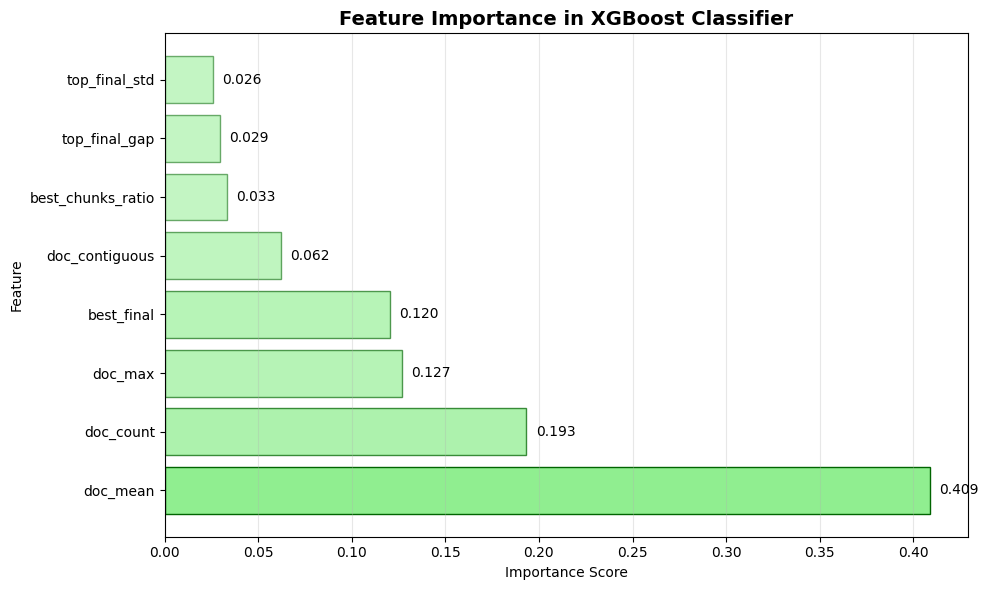


📈 FEATURE IMPORTANCE RANKING:
------------------------------------------------------------
1. doc_mean             0.4090 ████████████████████
2. doc_count            0.1933 █████████
3. doc_max              0.1268 ██████
4. best_final           0.1202 ██████
5. doc_contiguous       0.0622 ███
6. best_chunks_ratio    0.0334 █
7. top_final_gap        0.0294 █
8. top_final_std        0.0258 █

✅ FEATURE IMPORTANCE ANALYSIS COMPLETED!


In [ ]:
# BƯỚC 13F: FEATURE IMPORTANCE VISUALIZATION
#Bỏ qua
print("📊 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

if ml_classifier.is_trained and hasattr(ml_classifier.model, 'feature_importances_'):
    importances = ml_classifier.model.feature_importances_
    feature_names = ml_classifier.feature_names
    
    # Sort by importance
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = [importances[i] for i in indices]
    
    # Create figure
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(sorted_features)), sorted_importances, color='lightgreen', edgecolor='darkgreen')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance in XGBoost Classifier', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (feature, imp) in enumerate(zip(sorted_features, sorted_importances)):
        plt.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=10)
    
    # Add color gradient based on importance
    for i, bar in enumerate(bars):
        bar.set_alpha(0.5 + 0.5 * (sorted_importances[i] / max(sorted_importances)))
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("✅ Đã lưu visualization: feature_importance.png")
    plt.show()
    
    # Print ranking
    print(f"\n📈 FEATURE IMPORTANCE RANKING:")
    print("-"*60)
    for i, (feature, imp) in enumerate(zip(sorted_features, sorted_importances), 1):
        print(f"{i}. {feature:<20} {imp:.4f} {'█' * int(imp * 50)}")
    
    print(f"\n{'='*60}")
    print("✅ FEATURE IMPORTANCE ANALYSIS COMPLETED!")
    print("="*60)
    
else:
    print("⚠️  ML Classifier chưa được train hoặc không có feature_importances_!")

In [16]:
# BƯỚC 13G: PHÂN TÍCH TOP MATCHES (DEBUG)
print("🔍 DEBUG: TOP MATCH INSPECTOR")
print("="*60)

import textwrap

def inspect_top_matches(query_text, doc_limit=3, chunks_per_doc=3, context_window=1, max_query_preview=200):
    """Chạy detector rồi in chi tiết các chunk giống nhất để kiểm tra false positive."""
    if 'active_detector' not in globals():
        raise ValueError("active_detector chưa được khởi tạo")
    result = active_detector.detect(query_text, top_n_docs=max(doc_limit, 5), verbose=False)
    doc_scores = result['top_results']
    print(f"Query preview: {query_text[:max_query_preview]}{'...' if len(query_text) > max_query_preview else ''}")
    print(f"Bi-encoder confidence: {result['confidence']:.3f}")
    print(f"Top {doc_limit} documents:")
    for rank, doc_score in enumerate(doc_scores[:doc_limit], start=1):
        doc_id = doc_score['doc_id']
        meta_lookup = get_doc_metadata(doc_id) if 'get_doc_metadata' in globals() else {}
        source_title = doc_score.get('source_title') or meta_lookup.get('title')
        source_url = doc_score.get('source_url') or meta_lookup.get('source_url') or meta_lookup.get('url')
        published_at = doc_score.get('published_at') or meta_lookup.get('published_at') or meta_lookup.get('date')
        print(f"\n[{rank}] Doc {doc_id} | final={doc_score['final_score']:.3f} | max={doc_score['doc_max']:.3f} | count={doc_score['doc_count']:.2f}")
        if source_title:
            print(f"    Title: {source_title}")
        if source_url:
            print(f"    Source URL: {source_url}")
        if published_at:
            print(f"    Published: {published_at}")
        chunk_entries = sorted(doc_score['chunks'], key=lambda x: x['similarity'], reverse=True)[:chunks_per_doc]
        for idx, chunk_entry in enumerate(chunk_entries, start=1):
            chunk = chunk_entry['chunk']
            expanded = context_expander.expand_chunk_context(chunk, context_window=context_window)
            expanded = expanded.replace('\n', ' ')
            expanded = textwrap.shorten(expanded, width=220, placeholder='...')
            print(f"   - Chunk {idx}: sim={chunk_entry['similarity']:.3f} | pos={chunk['position']}")
            print(f"     Text: {expanded}")
    return result

print("Gọi inspect_top_matches(query_text) để xem chi tiết top matches.")

🔍 DEBUG: TOP MATCH INSPECTOR
Gọi inspect_top_matches(query_text) để xem chi tiết top matches.


In [19]:
# BƯỚC 13H: SO SÁNH THEO TỪNG CÂU TRONG QUERY
print("🧩 PHÂN RÃ QUERY THEO CÂU")
print("="*60)

import re
import textwrap

HIGHLIGHT_BORDER = "═" * 60

def highlight_sentence(sentence, width=96):
    wrapped = textwrap.fill(sentence, width=width)
    return f"\n{HIGHLIGHT_BORDER}\n⚠️  CÂU NGHI VẤN:\n{wrapped}\n{HIGHLIGHT_BORDER}"

def compare_query_sentences(query_text, min_words=6, doc_limit=3, chunks_per_doc=2, context_window=1):
    """Chia nhỏ query theo câu, highlight câu nghi vấn và in URL nguồn tương ứng."""
    if 'inspect_top_matches' not in globals():
        raise ValueError("Cần chạy cell Bước 13G trước để có inspect_top_matches")
    sentences = [s.strip() for s in re.split(r"(?<=[.!?…])\s+", query_text) if s.strip()]
    if not sentences:
        print("⚠️  Không tách được câu nào từ query!")
        return []
    sentence_reports = []
    for idx, sentence in enumerate(sentences, start=1):
        word_count = len(sentence.split())
        if word_count < min_words:
            print(f"\n[{idx}] Bỏ qua câu quá ngắn ({word_count} từ): {sentence}")
            continue
        print(f"\n[{idx}] CÂU VỚI {word_count} TỪ:")
        print(highlight_sentence(sentence))
        detection = inspect_top_matches(
            sentence,
            doc_limit=doc_limit,
            chunks_per_doc=chunks_per_doc,
            context_window=context_window,
            max_query_preview=180
        )
        doc_scores = detection.get('top_results', [])
        best_doc = doc_scores[0] if doc_scores else None
        meta_lookup = get_doc_metadata(best_doc['doc_id']) if (best_doc and 'get_doc_metadata' in globals()) else {}
        source_url = (best_doc.get('source_url') if best_doc else None) or meta_lookup.get('source_url') or meta_lookup.get('url')
        source_title = (best_doc.get('source_title') if best_doc else None) or meta_lookup.get('title')
        confidence = best_doc.get('final_score') if best_doc else 0.0
        if source_url:
            print(f"   → Source URL: {source_url}")
        else:
            print("   → Source URL: (không có)")
        if source_title:
            print(f"   → Title: {source_title}")
        sentence_reports.append({
            'sentence_index': idx,
            'sentence': sentence,
            'word_count': word_count,
            'best_doc_id': best_doc['doc_id'] if best_doc else None,
            'confidence': confidence,
            'source_url': source_url,
            'source_title': source_title
        })
    if not sentence_reports:
        print("⚠️  Không có câu nào đủ dài để phân tích.")
        return []
    print("\n📎 TỔNG HỢP NGUỒN THEO CÂU:")
    for report in sentence_reports:
        if not report['best_doc_id']:
            continue
        title_display = report['source_title'] or 'Không rõ tiêu đề'
        url_display = report['source_url'] or 'Không có URL'
        print(f" - Câu {report['sentence_index']} | score={report['confidence']:.3f} | doc={report['best_doc_id']}")
        print(f"   Title : {title_display}")
        print(f"   URL   : {url_display}")
    return sentence_reports

print("Gọi compare_query_sentences(query_text) để xem từng câu map vào văn bản nào.")

🧩 PHÂN RÃ QUERY THEO CÂU
Gọi compare_query_sentences(query_text) để xem từng câu map vào văn bản nào.


In [22]:
# DEMO: PHÂN TÍCH TỪNG CÂU CHO example_query
compare_query_sentences(example_query, doc_limit=2, chunks_per_doc=2)


[1] CÂU VỚI 36 TỪ:

════════════════════════════════════════════════════════════
⚠️  CÂU NGHI VẤN:
Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm:
Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu​) là một bãi ngầm dạng rạn vòng hoàn toàn
chìm dưới mặt nước Biển Đông.
════════════════════════════════════════════════════════════
Query preview: Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm: Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu​) là một bãi ngầm dạng rạn vòng h...
Bi-encoder confidence: 0.781
Top 2 documents:

[1] Doc doc_2924 | final=0.781 | max=0.961 | count=0.86
   - Chunk 1: sim=0.961 | pos=0
     Text: Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm: Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu​) là một bãi ngầm dạng rạn vòng hoàn toàn chìm dưới mặt nước Biển Đông...
   - Chunk 2: sim=0.813 | pos=1
     Text: Bãi Maccles

[{'sentence_index': 1,
  'sentence': 'Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm: Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu\u200b) là một bãi ngầm dạng rạn vòng hoàn toàn chìm dưới mặt nước Biển Đông.',
  'word_count': 36,
  'best_doc_id': 'doc_2924',
  'confidence': 0.7812780226027043,
  'source_url': None,
  'source_title': None},
 {'sentence_index': 2,
  'sentence': 'Bãi ngầm này nằm cách quần đảo Hoàng Sa 75 hải lý (139 km) về phía đông, ở vào khoảng giữa của đường hàng hải từ bờ biển miền Trung Việt Nam đến phía bắc đảo Luzon của Philippines.',
  'word_count': 39,
  'best_doc_id': 'doc_2924',
  'confidence': 0.3903076567262283,
  'source_url': None,
  'source_title': None},
 {'sentence_index': 3,
  'sentence': 'Tên gọi của bãi ngầm xuất phát từ sự kiện tàu Macclesfield của Anh khám phá ra bãi này vào năm 1701.',
  'word_count': 22,
  'best_doc_id': 'doc_2924',
  'confidence': 0.6397486790243244,
  'source_url': None,
  '

In [28]:
#  DEMO: CÁCH SỬ DỤNG DETECTOR + ML CLASSIFIER

example_query = """Trong những ngày vừa qua, câu chuyện một bé gái 13 tuổi ở phường Linh Sơn (Thái Nguyên) bị đánh đập bởi người trong gia đình đã gây phẫn nộ dư luận. Sau khi vào cuộc, ngày 21/11, Công an tỉnh Thái Nguyên đã ra quyết định khởi tố và bắt giữ ba người gồm Nguyễn Thị Bích Hằng (1969), Lương Quốc Trung (1971) và Nguyễn Ngọc Thành (1965). Cả ba cư trú tại Tổ dân phố Ao Vàng và bị điều tra về hành vi cố ý gây thương tích.

Sự việc xảy ra ngày 16/11/2025, khi cháu P.A bị nhóm người thân này hành hung, dẫn đến nhiều vết bầm trên cơ thể. Báo cáo giám định cho thấy tỷ lệ thương tích của cháu là 5%. Đáng nói, cả ba đối tượng đều có lịch sử phạm pháp: Hằng từng bị kết án vì lừa đảo, Trung có nhiều tiền án liên quan trộm cắp và bạo lực, còn Thành từng bị xử lý vì lừa đảo và ma túy. Kiểm tra nhanh cho thấy Hằng và Thành đều dương tính với ma túy.

Theo phân tích của Thượng tá Trịnh Kim Vân – nguyên điều tra viên cao cấp Công an Hà Nội – cơ quan điều tra đã thu thập đầy đủ chứng cứ như lời khai những người liên quan, kết quả giám định và tang vật. Với những tài liệu đã có, việc khởi tố về tội cố ý gây thương tích là hoàn toàn có căn cứ. Hành vi sử dụng các vật dụng như chổi, gậy, cuốc, chảo… để đánh bé gái được xem là nghiêm trọng và cần xử lý nghiêm minh.

Ông Vân cũng cho biết vụ việc này có nhiều yếu tố tăng nặng trách nhiệm hình sự, và đây sẽ là cơ sở quan trọng khi xem xét mức độ xử phạt sau này."""
print("="*60)
print("🧪 DEMO: PLAGIARISM DETECTION")
print("="*60)
print(f"Query text:\n{example_query}\n")

result = complete_detector_v2.detect(example_query, verbose=False)

print(f"📊 DETECTOR RESULT:")
print(f"   Confidence: {result['confidence']:.3f}")
if result['best_match']:
    print(f"   Best match: {result['best_match']['doc_id']}")
else:
    print("   Best match: None")

if ml_classifier.is_trained:
    ml_result = ml_classifier.predict(result)
    print(f"\n ML CLASSIFIER RESULT:")
    print(f"   Prediction: {'PLAGIARISM' if ml_result['prediction'] else 'ORIGINAL'}")
    print(f"   Confidence: {ml_result['confidence']:.3f}")
    print(f" FEATURE VALUES:")
    for feature, value in ml_result['features'].items():
        print(f"   {feature:<20} {value:.4f}")
else:
    print("\n⚠️  ML Classifier chưa được train!")

print(f"\n{'='*60}")
print(" DEMO COMPLETED!")
print("="*60)


🧪 DEMO: PLAGIARISM DETECTION
Query text:
Trong những ngày vừa qua, câu chuyện một bé gái 13 tuổi ở phường Linh Sơn (Thái Nguyên) bị đánh đập bởi người trong gia đình đã gây phẫn nộ dư luận. Sau khi vào cuộc, ngày 21/11, Công an tỉnh Thái Nguyên đã ra quyết định khởi tố và bắt giữ ba người gồm Nguyễn Thị Bích Hằng (1969), Lương Quốc Trung (1971) và Nguyễn Ngọc Thành (1965). Cả ba cư trú tại Tổ dân phố Ao Vàng và bị điều tra về hành vi cố ý gây thương tích.

Sự việc xảy ra ngày 16/11/2025, khi cháu P.A bị nhóm người thân này hành hung, dẫn đến nhiều vết bầm trên cơ thể. Báo cáo giám định cho thấy tỷ lệ thương tích của cháu là 5%. Đáng nói, cả ba đối tượng đều có lịch sử phạm pháp: Hằng từng bị kết án vì lừa đảo, Trung có nhiều tiền án liên quan trộm cắp và bạo lực, còn Thành từng bị xử lý vì lừa đảo và ma túy. Kiểm tra nhanh cho thấy Hằng và Thành đều dương tính với ma túy.

Theo phân tích của Thượng tá Trịnh Kim Vân – nguyên điều tra viên cao cấp Công an Hà Nội – cơ quan điều tra đã thu

In [23]:
inspect_top_matches(example_query, doc_limit=3, chunks_per_doc=3)

Query preview: Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm: Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu​) là một bãi ngầm dạng rạn vòng hoàn toàn chìm dưới m...
Bi-encoder confidence: 0.858
Top 3 documents:

[1] Doc doc_2924 | final=0.858 | max=1.000 | count=1.00
   - Chunk 1: sim=1.000 | pos=2
     Text: Trung Hoa Dân Quốc (Đài Loan) và Cộng hòa Nhân dân Trung Hoa (Trung Quốc) đều tuyên bố chủ quyền đối với bãi Macclesfield Bãi ngầm Macclesfield là một rạn san hô vòng lớn nằm trên cực đông của sườn lục địa phía tây...
   - Chunk 2: sim=1.000 | pos=3
     Text: Vành ám tiêu của Macclesfield rộng trung bình khoảng 4,8 km, trên đó là hàng loạt các bãi cạn có độ sâu dưới 20 m Nơi nông nhất của vành này là tại điểm mút đông bắc của bãi cạn Pigmy (tiếng Anh: Pigmy Shoal) với độ...
   - Chunk 3: sim=1.000 | pos=6
     Text: Một số học giả đặt ra câu hỏi về tính hợp pháp của hành động tuyên bố chủ quyền đối với bãi Macclesfield vì theo

{'prediction': True,
 'confidence': 0.8581490312884626,
 'threshold': 0.6,
 'best_match': {'doc_id': 'doc_2924',
  'doc_max': 1.0000004768371582,
  'doc_mean': 1.000000034059797,
  'doc_count': 1.0,
  'doc_contiguous': 1.0,
  'final_score': 0.8581490312884626,
  'raw_score': 1.0000001975468227,
  'chunk_similarity_std': 3.231196056265537e-07,
  'position_span_ratio': 1.0,
  'chunk_density': 1.0,
  'contiguous_len': 7,
  'chunks': [{'similarity': 1.0000004768371582,
    'chunk': {'chunk_id': 'doc_2924_chunk_2',
     'doc_id': 'doc_2924',
     'text': 'Vành ám tiêu của Macclesfield rộng trung bình khoảng 4,8 km, trên đó là hàng loạt các bãi cạn có độ sâu dưới 20 m Nơi nông nhất của vành này là tại điểm mút đông bắc của bãi cạn Pigmy (tiếng Anh: Pigmy Shoal) với độ sâu 11,9 m Trong khi đó, nơi nông nhất của bãi ngầm là bãi cạn Walker (tiếng Anh: Walker Shoal, sâu 9,2 m) nằm bên trong vụng biển của bãi ngầm',
     'position': 2,
     'length': 78},
    'chunk_idx': 33554},
   {'similarity'

In [24]:
compare_query_sentences(example_query)


[1] CÂU VỚI 36 TỪ:

════════════════════════════════════════════════════════════
⚠️  CÂU NGHI VẤN:
Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm:
Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu​) là một bãi ngầm dạng rạn vòng hoàn toàn
chìm dưới mặt nước Biển Đông.
════════════════════════════════════════════════════════════
Query preview: Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm: Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu​) là một bãi ngầm dạng rạn vòng h...
Bi-encoder confidence: 0.781
Top 3 documents:

[1] Doc doc_2924 | final=0.781 | max=0.961 | count=0.86
   - Chunk 1: sim=0.961 | pos=0
     Text: Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm: Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu​) là một bãi ngầm dạng rạn vòng hoàn toàn chìm dưới mặt nước Biển Đông...
   - Chunk 2: sim=0.813 | pos=1
     Text: Bãi Maccles

[{'sentence_index': 1,
  'sentence': 'Bãi Macclesfield (Mác-léc-phiên; tiếng Anh: Macclesfield Bank; tiếng Trung: 中沙大环礁; bính âm: Zhōngshā Dàhuán Jiāo; Hán-Việt: Trung Sa Đại Hoàn tiêu\u200b) là một bãi ngầm dạng rạn vòng hoàn toàn chìm dưới mặt nước Biển Đông.',
  'word_count': 36,
  'best_doc_id': 'doc_2924',
  'confidence': 0.7812780226027043,
  'source_url': None,
  'source_title': None},
 {'sentence_index': 2,
  'sentence': 'Bãi ngầm này nằm cách quần đảo Hoàng Sa 75 hải lý (139 km) về phía đông, ở vào khoảng giữa của đường hàng hải từ bờ biển miền Trung Việt Nam đến phía bắc đảo Luzon của Philippines.',
  'word_count': 39,
  'best_doc_id': 'doc_2924',
  'confidence': 0.3903076567262283,
  'source_url': None,
  'source_title': None},
 {'sentence_index': 3,
  'sentence': 'Tên gọi của bãi ngầm xuất phát từ sự kiện tàu Macclesfield của Anh khám phá ra bãi này vào năm 1701.',
  'word_count': 22,
  'best_doc_id': 'doc_2924',
  'confidence': 0.6397486790243244,
  'source_url': None,
  '